## Оптимизация производственных расходов

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Загрузка данных

In [520]:
!gdown --id 1SU-0z4ZmcxyoDuBYSRHLa7s3Vv-wP3KU
!gdown --id 1AsH70SJ4t1RnvQTs6yVFDfTIy_jisEW2
!gdown --id 15zQDRCP12dFznRzZ6f0xErxAlDF3kFtz
!gdown --id 1aQVSb1KYFVzIywoXxFxROqkC3UmszX6r
!gdown --id 18W09IksnjAznhfPUeya88Bj-cU3zcB8f
!gdown --id 1UGDh2Z292GXITUVVorQOqv2727OyQjmT
!gdown --id 11TV2E0ed7lzNx5F3yjgIpdPFJM0ZD1VW

Downloading...
From: https://drive.google.com/uc?id=1SU-0z4ZmcxyoDuBYSRHLa7s3Vv-wP3KU
To: /content/data_arc.csv
100% 1.10M/1.10M [00:00<00:00, 28.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AsH70SJ4t1RnvQTs6yVFDfTIy_jisEW2
To: /content/data_bulk_time.csv
100% 274k/274k [00:00<00:00, 38.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=15zQDRCP12dFznRzZ6f0xErxAlDF3kFtz
To: /content/data_bulk.csv
100% 115k/115k [00:00<00:00, 42.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aQVSb1KYFVzIywoXxFxROqkC3UmszX6r
To: /content/data_gas.csv
100% 63.8k/63.8k [00:00<00:00, 49.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=18W09IksnjAznhfPUeya88Bj-cU3zcB8f
To: /content/data_temp.csv
100% 486k/486k [00:00<00:00, 64.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UGDh2Z292GXITUVVorQOqv2727OyQjmT
To: /content/data_wire_time.csv
100% 125k/125k [00:00<00:00, 37.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=11TV2E0ed7lzNx5F3yjgIpdP

In [521]:
pip install catboost

In [522]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
from catboost import Pool, CatBoostRegressor, cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor

In [523]:
data_arc = pd.read_csv('/content/data_arc.csv')
data_bulk = pd.read_csv('/content/data_bulk.csv')
data_bulk_time = pd.read_csv('/content/data_bulk_time.csv')
data_gas = pd.read_csv('/content/data_gas.csv')
data_temp = pd.read_csv('/content/data_temp.csv')
data_wire = pd.read_csv('/content/data_wire.csv')
data_wire_time = pd.read_csv('/content/data_wire_time.csv')

## Просмотр данных

### Просмотр табличной информации

In [524]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Из данных, представленных в таблице, видим продолжительность воздействия на сплав электродами для ее нагрева, а также потребляемую мощность.

In [525]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Из таблицы видно, что для конкретной партии подается определенная категория сыпучего материала в определенном объеме. В процессе производства задействованы не все категории сыпучих материалов.

In [526]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Фиксируется время подачи сыпучего материала. Из таблицы видно, что некоторые сыпучие материалы подавались одновременно.

In [527]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Из таблицы видим объем инертного газа, который потребовался для производства определенной партии стали.

In [528]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Из таблицы видим, что во время производства партии стали, несколько раз осуществляется замер температуры сплава: первый раз когда сплав выливают в ковш, затем перед первым вводом лигирующих добавок, и так, до окончания цикла производства.

In [529]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из таблицы видим объем проволочных материалов, задействованных при производстве партии стали. Видим, что для некоторых партий стали, проволочный материал подавался ни один раз.

In [530]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из данных видим, во сколько подавалася тот или иной проволочный материал.

### Посмотр структуры табличных данных

In [531]:
for data in [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]:
    print(data.info())
    print('-----------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64

В таблице data_arc пропущенных значений нет, но тип данных object для столбцов "Начало нагрева дугой", "Конец нагрева дугой" необходимо будет преобразовать в тип данных, удобный для работы с датой, временем, - datetime.  
В таблице data_bulk много пропущенных значений, которые образовались из-за того, что что в процессе сталилитейного производства не все сыпучие материалы задействуются. Данные пропуски будут в дальнейшем обработаны.  
В таблице data_bulk_time также много проущенных значений по той же причине, что и в таблице data_bulk. Также у столбцов Bulk1, Bulk2 и т.д. тип данных object.  
В таблице data_gas пропусков нет, типы данных корректны.  
В таблице data_temp есть пропущенные значения для поля Температура. В дальнейшем данные пропуски будут обработаны.  
В таблице data_wire есть пропущенные значения по той же причине, что и в таблице data_bulk.  
В таблице data_wire_time также много проущенных значений по той же причине, что и в таблице data_wire. 


Также можно заметить, что по всем таблицам прослеживается некорректность наименования столбцов, переименуем их в соответствии с принципом snake_case для удобства работы с данными:

In [532]:
data_arc.columns = ['key', 'arc_heating_start', 'arc_heating_stop',
       'active_power', 'reactive_power']

In [533]:
data_bulk = data_bulk.rename(columns=lambda x: x.replace('B', 'b'))
data_bulk = data_bulk.rename(columns=lambda x: x.replace(' ', '_'))

In [534]:
data_bulk_time = data_bulk_time.rename(columns=lambda x: x.replace('B', 'b'))
data_bulk_time = data_bulk_time.rename(columns=lambda x: x.replace(' ', '_'))

In [535]:
data_gas.columns = ['key', 'gas']

In [536]:
data_temp.columns = ['key', 'measure_time', 'temperature']

In [537]:
data_wire = data_wire.rename(columns=lambda x: x.replace('W', 'w'))
data_wire = data_wire.rename(columns=lambda x: x.replace(' ', '_'))

In [538]:
data_wire_time = data_wire_time.rename(columns=lambda x: x.replace('W', 'w'))
data_wire_time = data_wire_time.rename(columns=lambda x: x.replace(' ', '_'))

## Обработка и анализ данных

### Обработка пропусков

Предположим, что если в таблицах data_bulk, data_bulk_time, data_wire, data_wire_time есть пропущенные значения NaN, значит данный материал не был задействован в сталелитейном производстве. Соответственно, данные значения можно заменить на 0 (так как для модели непосредственно таблицы data_bulk_time и data_wire_time не потребуются, обработаем пропуски только в таблицах data_bulk и data_wire):

In [539]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

Посмотрим на пропуски в таблице data_temp:

In [540]:
data_temp[data_temp['temperature'].isnull()].head()

,key,measure_time,temperature
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


Мы видим, что по какой-то причине, во время производственного процесса значения температуры были замерены не для всех циклов. Определим процентное соотношение отсутсвующих значений:

In [541]:
len(data_temp[data_temp['temperature'].isnull()])/len(data_temp)

0.18237254039102282

В имеющихся данных температура замерена только в 82% случаев. При замене целевого признака медианным значением или любым другим, можем получить достаточно большую ошибку в работе модели, поэтому удалим строки, в которых отсутсвует замер температуры: 

In [542]:
data_temp.dropna(subset=['temperature'], inplace=True)

### Поиск дубликатов

In [543]:
for data in [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]:
  print(data.duplicated().sum())

0
0
0
0
0
0
0


Дубликаты в данных отсутсвуют.

### Изменение типов данных

In [544]:
data_arc['arc_heating_start'] = pd.to_datetime(data_arc['arc_heating_start'])
data_arc['arc_heating_stop'] = pd.to_datetime(data_arc['arc_heating_stop'])
data_temp['measure_time'] = pd.to_datetime(data_temp['measure_time'])

In [545]:
data_bulk_time.iloc[:, 1:16] = data_bulk_time.iloc[:, 1:16].apply(pd.to_datetime, errors='coerce')
data_wire_time.iloc[:, 1:10] = data_wire_time.iloc[:, 1:10].apply(pd.to_datetime, errors='coerce')

### Предварительный анализ данных

Проанализируем данные таблицы data_gas:

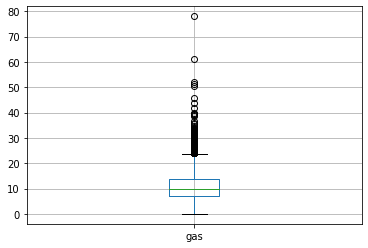

In [546]:
data_gas.boxplot(column='gas')
plt.show()

In [547]:
len(data_gas.query('gas > 25'))/len(data_gas)*100

3.118246372337141

3,1% данных выходят за пределы "верхнего уса" диаграммы размаха.

Проанализируем распределение температурных значений в таблице data_temp:

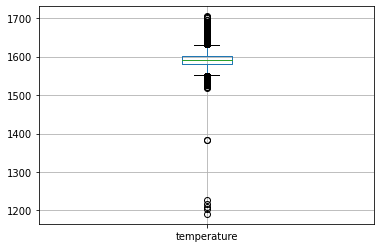

In [548]:
data_temp.boxplot(column='temperature')
plt.show()

Из диаграммы размаха видим, что есть аномально низкие и аномально высокие значения температуры. Удалим из выборки значения температуры меньше 1400:

In [549]:
data_temp = data_temp.query('temperature > 1400')

Проанализируем данные таблицы data_arc:

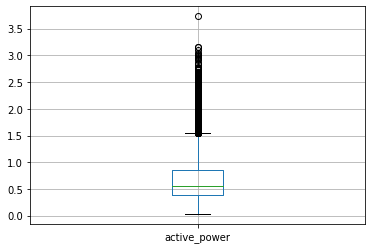

In [550]:
data_arc.boxplot(column='active_power')
plt.show()

In [551]:
len(data_arc.query('active_power > 1.7'))/len(data_arc)*100

2.588061306802904

Около 2,6% значений имеют активную мощность > 1,7.

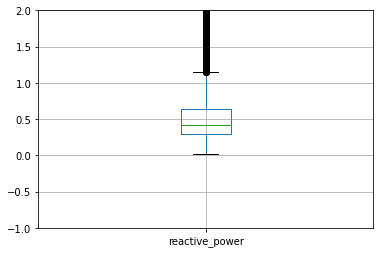

In [552]:
data_arc.boxplot(column='reactive_power')
plt.ylim(-1, 2)
plt.show()

In [553]:
len(data_arc.query('reactive_power < 0 or reactive_power > 1.3'))/len(data_arc)*100

2.7023393385318633

Около 2,7% значений имеют аномальные значения реактивной мощности.

In [554]:
len(data_arc.query('reactive_power > active_power'))/len(data_arc)*100

2.796450658779242

2,8% данных имеют сбой в энергетической системе, при которой реактивная мощность больше активной.

Для того, чтобы принимать решение об удалении выбросов, требуется дополнительное взаимодействие с бизнес-заказчиком, ведь данные сбои, аномалии  могут быть в пределах допуска производственного процесса. Так как мы этого наверняка не знаем, то удалять их не будем.

Посчитаем полную мощность и добавим ее к данным:

In [555]:
data_arc['full_power'] = (data_arc['active_power']*data_arc['active_power'] + data_arc['reactive_power']*data_arc['reactive_power'])**0.5

Проанализируем получившиеся значения полной мощности:

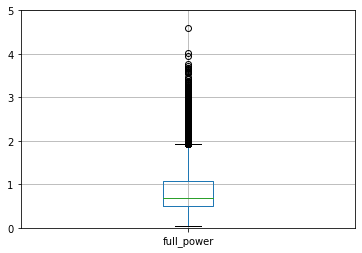

In [556]:
data_arc.boxplot(column='full_power')
plt.ylim(0, 5)
plt.show()

In [557]:
len(data_arc.query('full_power > 1.9'))/len(data_arc)*100

4.208120462489917

Количество значений, превышающих пределы "верхнего уса", для полной мощности составило 4,2%.

Добавим в таблицу data_arc признак работы, полученный как произведение продолжительности нагрева электродами на полную мощность:

In [558]:
data_arc['time_start'] = pd.to_timedelta(pd.to_datetime(data_arc['arc_heating_start']).dt.strftime('%d.%m.%Y H:%M:%S')).dt.total_seconds().astype(float)
data_arc['time_stop'] = pd.to_timedelta(pd.to_datetime(data_arc['arc_heating_stop']).dt.strftime('%d.%m.%Y H:%M:%S')).dt.total_seconds().astype(float)
data_arc['work'] = abs((data_arc['time_stop'] - data_arc['time_start']) * data_arc['full_power'])

In [559]:
data_arc = data_arc.drop(['time_start', 'time_stop'], axis=1)

Проанализируем распределение данного признака:

In [560]:
data_arc['work'].describe()

count    14876.000000
mean       346.662861
std       1059.888545
min          0.403301
25%         54.717501
50%        105.936994
75%        257.530840
max      77990.055458
Name: work, dtype: float64

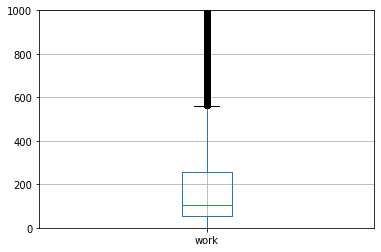

In [561]:
data_arc.boxplot(column='work')
plt.ylim(0, 1000)
plt.show()

In [562]:
len(data_arc.query('work > 550'))/len(data_arc)*100

10.473245496101102

Получили давольно большой разброс значений. Оставим данный признак для обучения модели.

Просуммируем все значения для каждой партии в таблице data_arc, кроме начального и конечного времени нагрева, так как они учтены в признаке "work":

In [563]:
data_arc = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power', 'full_power', 'work'], aggfunc='sum').reset_index()

Проверим данные на адекватность с помощью таблиц data_bulk_time, data_wire_time и date_temp, исходя из логики того, что последний замер температуры должен быть после добавления сыпучих или проволочных материалов:

In [564]:
data_union_time = data_bulk_time.merge(data_wire_time, on='key', how='inner')

In [565]:
cols = ['bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8','bulk_9','bulk_10','bulk_11', 
        'bulk_12','bulk_13','bulk_14','bulk_15', 'wire_1','wire_2',
        'wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
data_union_time['last_bulk_or_wire_time'] = data_union_time[cols].max(axis=1)

In [566]:
data_temp_first = data_temp.pivot_table(index='key', values='measure_time', aggfunc='min').reset_index()

In [567]:
data_temp_first.columns = ['key', 'min_measure_time']

In [568]:
data_temp_last = data_temp.pivot_table(index='key', values='measure_time', aggfunc='max').reset_index()

In [569]:
data_temp_last.columns = ['key', 'max_measure_time']

In [570]:
data_temp_new = data_temp_first.merge(data_temp_last)

In [571]:
data_union_time = data_union_time.merge(data_temp_new, on='key', how='inner')

In [572]:
data_union_time['compare_time'] = data_union_time['last_bulk_or_wire_time'] < data_union_time['max_measure_time']

In [573]:
data_union_time['compare_time'].value_counts()

True     2333
False     691
Name: compare_time, dtype: int64

Для 691 партии не произведено замера температуры после засыпания сыпучего или проволочного материала, удалим данные строки из выборки:

In [574]:
data_union_time = data_union_time.drop(data_union_time.query('compare_time == False').index)

### Объединение данных

Для дальнейшего моделирования объединим данные в одну выборку по ключевому полю 'key', но перед этим сгруппируем данные в таблице data_temp_union с целевым признаком последнего и первого замеров температуры:

In [575]:
data_temp_max = data_temp_new.merge(data_temp)
data_temp_max['new'] = data_temp_max['max_measure_time'] == data_temp_max['measure_time']
data_temp_max = data_temp_max.drop(data_temp_max.query('new == False').index)
data_temp_max = data_temp_max.drop('new', axis=1)

In [576]:
data_temp_min = data_temp_new.merge(data_temp)
data_temp_min['new'] = data_temp_min['min_measure_time'] == data_temp_min['measure_time']
data_temp_min = data_temp_min.drop(data_temp_min.query('new == False').index)
data_temp_min = data_temp_min.drop('new', axis=1)

In [577]:
data_temp_union = data_temp_max.merge(data_temp_min, on='key', how = 'outer')

In [578]:
data_temp_union = data_temp_union.drop(['min_measure_time_x', 'max_measure_time_x', 'measure_time_x', 'min_measure_time_y', 'max_measure_time_y', 'measure_time_y'], axis=1)

Объединим данные:

In [579]:
df = data_arc.merge(data_bulk)
df = df.merge(data_wire)
df = df.merge(data_gas)
df = df.merge(data_temp_union)

Объединим датафрейм для модели df с таблицей data_union_time, из которой удалены партии без конечного замера температуры:

In [580]:
data_union_time = data_union_time['key']

In [581]:
df = df.merge(data_union_time, on='key', how='right')

### Получение итогового датафрейма

In [582]:
df = df.drop('key', axis=1)

In [583]:
df = df.dropna()

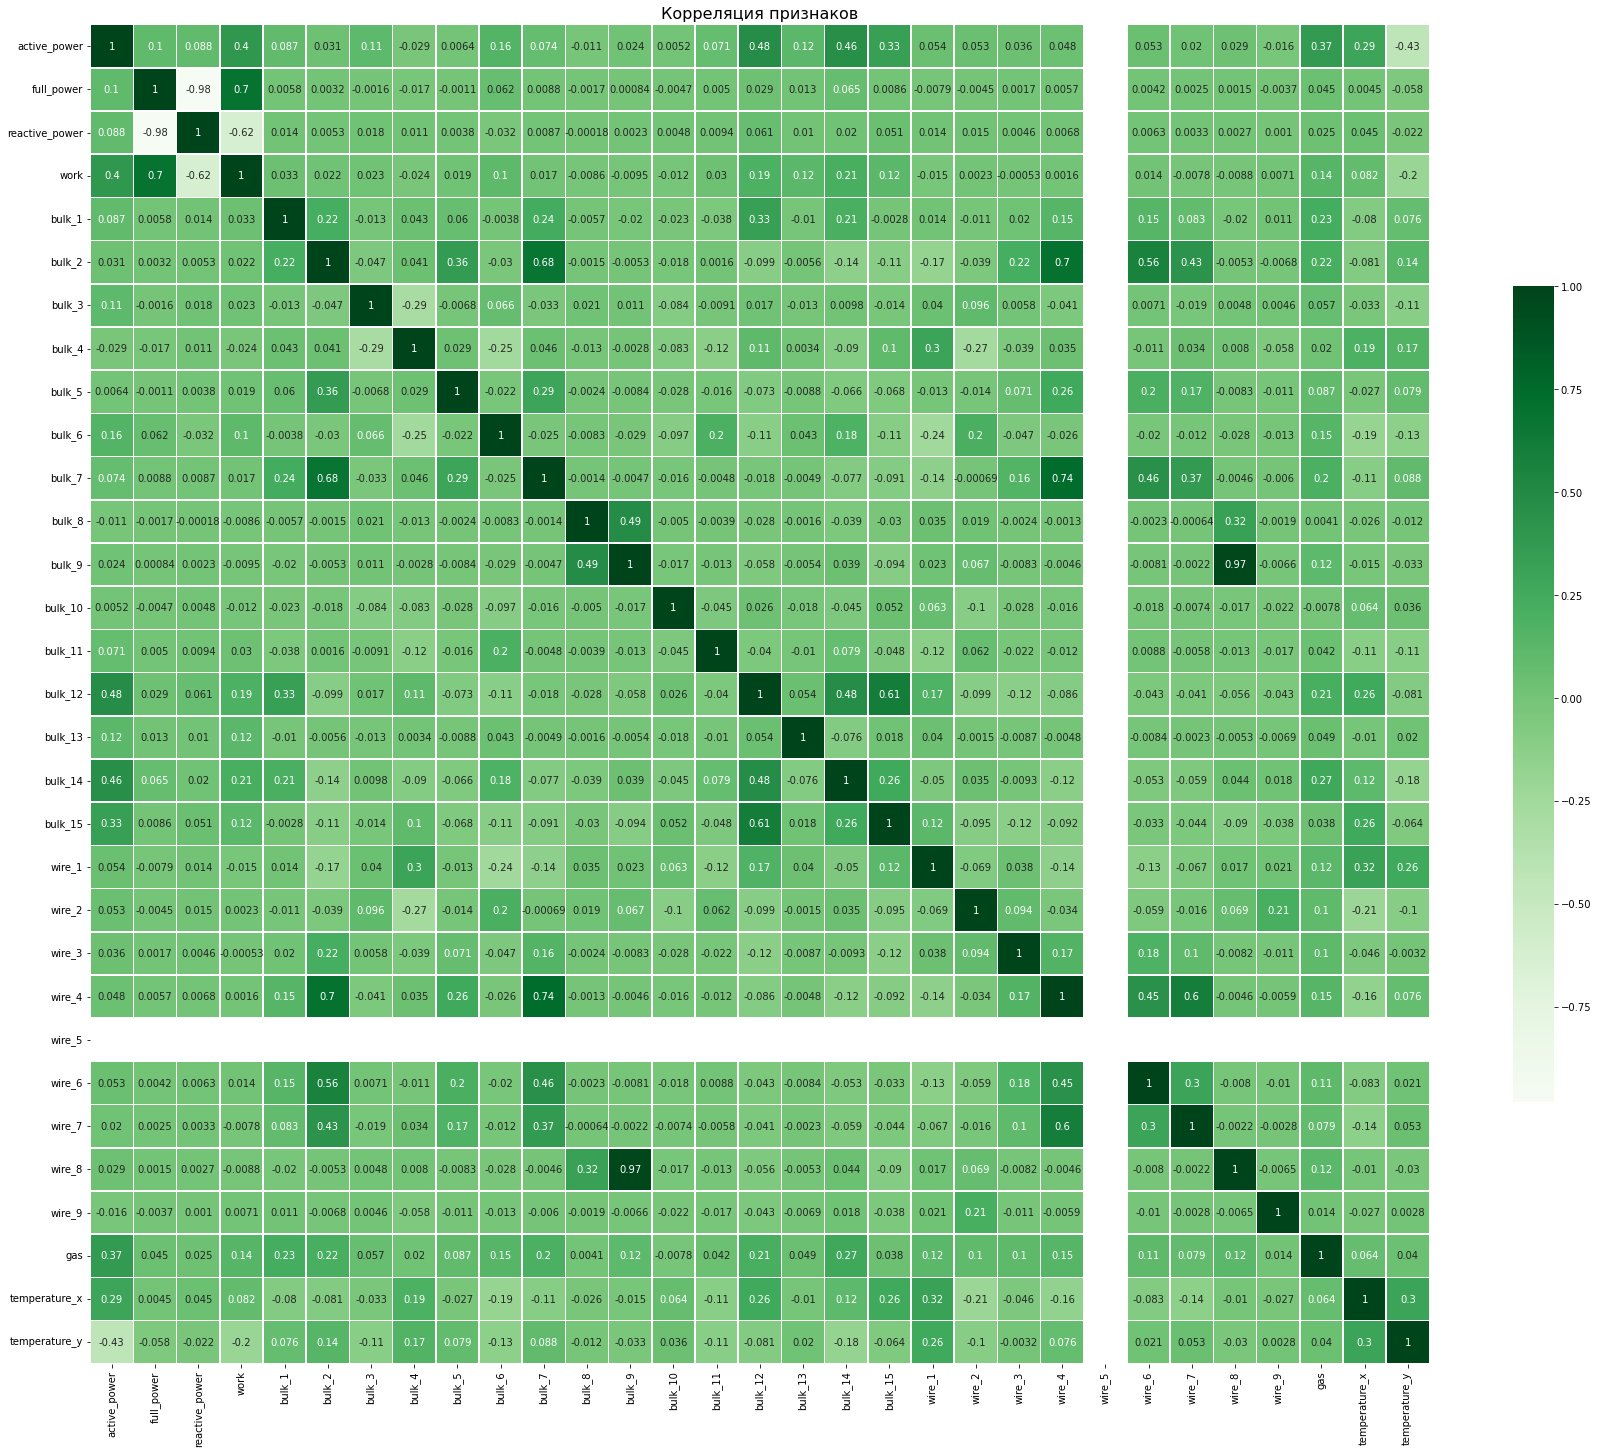

In [584]:
corr = df.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, center=0, annot=True, cmap='Greens', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Корреляция признаков', size=16)
plt.show()

Наблюдаем сильную обратную корреляцию между полной мощностью и реактивной, удалим из финальной выборки реактивную мощность:

In [585]:
df = df.drop('reactive_power', axis=1)

Финальная выборка:

In [586]:
df.head()

,active_power,full_power,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas,temperature_x,temperature_y
0,4.878147,5.826395,1442.377754,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0,1571.0
1,3.052598,3.649216,881.233565,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0,1581.0
2,2.525882,2.989534,525.066777,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0,1596.0
3,3.209250,3.814962,796.911309,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0,1601.0
4,3.347173,4.035758,1199.137958,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0,1576.0


## Моделирование

Разбьем данные на выбороки:

In [587]:
SEED = 42

In [588]:
target = df['temperature_x']
features = df.drop('temperature_x', axis=1)

In [589]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=SEED)

In [590]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1864, 29), (466, 29), (1864,), (466,))

Масштабируем признаки:

In [591]:
numeric = features_train.columns

In [592]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [593]:
result = []

Построим модель градиентного бустинга с помощью библиотеки CatBoost:

In [594]:
model_cat = CatBoostRegressor(loss_function='MAE', iterations=250, random_seed=5, verbose=False)
parameters_cat = {'depth': [5, 11, 2], 'learning_rate': np.arange(.1, 1, .2), 'iterations': [30, 250]}
cat_grid = GridSearchCV(model_cat, parameters_cat, cv = 5, n_jobs = -1)
cat_grid.fit(features_train, target_train)
print(cat_grid.best_params_, end = '\n\n')

{'depth': 2, 'iterations': 250, 'learning_rate': 0.30000000000000004}



In [595]:
model_cat_best = CatBoostRegressor(depth = 5, learning_rate= 0.1, iterations = 250)
model_cat_best.fit(features_train, target_train,  verbose=False)
predict_cat = model_cat_best.predict(features_train)
mae_cat = mean_absolute_error(target_train, predict_cat)

In [596]:
predict_cat_test = model_cat_best.predict(features_test)
mae_cat_test = mean_absolute_error(target_test, predict_cat_test)

In [597]:
result.append({'Модель': 'CatBoostRegressor', 
               'MAE_train': mae_cat,
               'MAE_test': mae_cat_test})

Построим модель линейной регрессии:

In [598]:
model_lr = LinearRegression(n_jobs=-1)
model_lr.fit(features_train, target_train)
predict_lr = model_lr.predict(features_train)
mae_lr = mean_absolute_error(target_train, predict_lr)

In [599]:
predict_lr_test = model_lr.predict(features_test)
mae_lr_test = mean_absolute_error(target_test, predict_lr_test)

In [600]:
result.append({'Модель': 'LinearRegression', 
               'MAE_train': mae_lr,
               'MAE_test': mae_lr_test})

Построим модель градиентного бустинга с помощью библиотеки LightGBM:

In [601]:
parameters_lgbm = {'n_estimators': [300, 600, 1000, 1500, 2500],
                   'max_depth':  [4, 9, 15],
                   'learning_rate': [0.1, 0.3]}

est = LGBMRegressor(boosting_type='gbdt', random_state=12345)

gs = GridSearchCV(est, parameters_lgbm, scoring='neg_mean_absolute_error', cv=2, verbose=1)
gs_results = gs.fit(features_train, target_train)
print("BEST PARAMETERS: " + str(gs_results.best_params_))

Fitting 2 folds for each of 30 candidates, totalling 60 fits
BEST PARAMETERS: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}


In [602]:
model_lgbm = LGBMRegressor(max_depth = 4, learning_rate = 0.1, n_estimators = 300)
model_lgbm.fit(features_train, target_train)
predict_lgbm = model_lgbm.predict(features_train)
mae_lgbm = mean_absolute_error(target_train, predict_lgbm)

In [603]:
predict_lgbm_test = model_lgbm.predict(features_test)
mae_lgbm_test = mean_absolute_error(target_test, predict_lgbm_test)

In [604]:
result.append({'Модель': 'LGBMRegressor', 
               'MAE_train': mae_lgbm,
               'MAE_test': mae_lgbm_test})

Построим модель случайного леса

In [605]:
model_rf = RandomForestRegressor()

grid_rf = {'max_depth': [10, 40,100,300],
           'n_estimators': [100, 200, 300, 500]}


rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = grid_rf, scoring='neg_mean_absolute_error', cv = 3)
rf_random_results = rf_random.fit(features_train, target_train)
print("BEST PARAMETERS: " + str(rf_random_results.best_params_))

BEST PARAMETERS: {'n_estimators': 200, 'max_depth': 10}


In [606]:
model_rf = RandomForestRegressor(n_estimators= 300, max_depth= 10)
model_rf.fit(features_train,target_train)
predict_rf = model_rf.predict(features_train)
mae_rf = mean_absolute_error(target_train, predict_rf)

In [607]:
predict_rf_test = model_rf.predict(features_test)
mae_rf_test = mean_absolute_error(target_test, predict_rf_test)

In [608]:
result.append({'Модель': 'RandomForestRegressor', 
               'MAE_train': mae_rf,
               'MAE_test': mae_rf_test})

Проверим модели на адекватность с помощью DummyRegressor:

In [609]:
dummy = DummyRegressor(strategy="median")
dummy.fit(features_train,target_train)
predict_dr = dummy.predict(features_train)
mae_dr = mean_absolute_error(target_train, predict_dr)

In [610]:
predict_dr_test = dummy.predict(features_test)
mae_dr_test = mean_absolute_error(target_test, predict_dr_test)

In [611]:
result.append({'Модель': 'DummyRegressor', 
               'MAE_train': mae_dr,
               'MAE_test': mae_dr_test})

In [612]:
pd.DataFrame(result)

,Модель,MAE_train,MAE_test
0,CatBoostRegressor,4.167702,6.210703
1,LinearRegression,5.941854,6.531638
2,LGBMRegressor,3.701508,6.503016
3,RandomForestRegressor,3.570341,6.441867
4,DummyRegressor,8.119635,8.015021


Наименьшей ошибки на тестовых данных удалось добиться с помощью модели CatBoostRegressor: МАЕ = 6.21.  
Проверку на адекватность прошли все модели.

### Анализ важности факторов

Построим график важности факторов, влияющих на построение предсказаний модели:

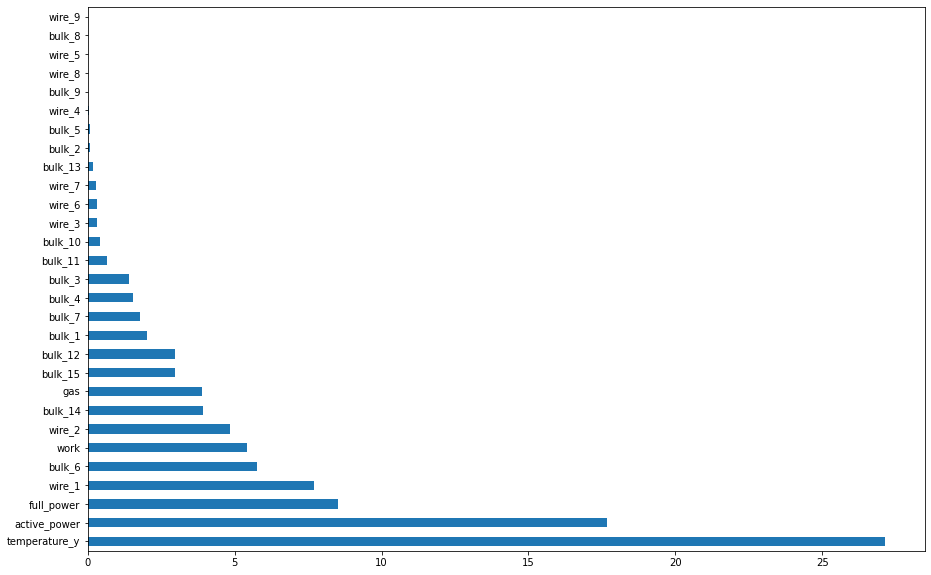

In [613]:
pd.Series(model_cat_best.feature_importances_, index = features_train.columns).nlargest(len(features_train)).plot(kind='barh', figsize=(15, 10))
plt.show()

Из графика видим, что наиболее важным для итогового предсказания фактором является первоначальная температура сплава, далее по важности следует активная мощность, немаловажными фактороми также оказались проволочный материал work_1, сыпучий материал bulk_6, полная мощность и работа.

## Список уточняющих вопросов:

1. В результате предварительного анализа получены аномальные значения для таких параметров как объем подаваемого газа, мощности, температуры. Считать ли их допустимыми в ходе технологического процесса (к примеру, энергетический сбой также может повлиять на температуру нагрева сплава) или очистить от них выборку?
2. Целевым признаком является конечная температура партии, на сколько важно учитывать влияние начальных и промежуточных значений измерения температуры? К примеру, есть партии, первоначальная температура нагрева смеси которых, значительно меньше 1500. Но из технологического процесса производства стали известно, что первоначально заливается расплавленный чугун, который как раз и имеет температуру порядка 1200-1300.

## План

1. Провести предварительную обработку данных: работа с пропущенными значениями, поиск дубликатов, работа с наименованиями столбцов.
2. Провести анализ данных: поиск аномальных значений, проверка данных на адекватность, аггрегирование данных.
3. Моделирование: подбор моделей, параметров, оценка качества моделей.
4. Многофакторный анализ: ранжирование факторов по степени влияния на предсказание целевого признака.
5. Выводы.

## Вывод

В результате проделанной работы осуществлена предварительная обработка данных: обработаны пропущенные значения, выполнен поиск дубликатов, скорректированы наименования столбцов.  
Далее выполнен анализ данных:
- поиск выбросов с их частичным удалением: удалены партии с первоначальной температурой сплава в районе 1200. Остальные аномалии принято решение не удалять, так как они могут быть в пределах допуска технологического процесса (требуется дополнительное взаиможействие с бизнес-заказчиком);
- данные проверены на адекватность: удалены партии, для которых не было финального замера температуры после добавления сыпучего или проволочного материала;
- данные проверены на мульиколлениарность: определены сильно коррелирующие друг с другом признаки с последующим удалением одного из них;
- выполнено аггрегирование данных, необходимое для дальнейшего моделирования.  
В процессе моделирования осуществлено разбиение данных на тренировочную и тестовую выборки, масштабирование признаков. В качестве моделей выбраны:
- CatBoostRegressor,
- LinearRegression,
- LGBMRegressor,
- RandomForestRegressor.  
Все модели прошли проверку на адекватность с помощью DummyRegressor.  
Наименьшую ошибку показала модель CatBoostRegressor с МАЕ = 6,21.  
В ходе работы выполнен многофакторын анализ: более всего на предсказание конечной температуры оказывает влияние начальная температура сплава, также сильно влияние мощности электродов, сыпучего материала bulk_6 и проволочного материала wire_1.  
Многофакторный анализ показывает, что для оптимизации производсвенных расходов, очень важно проанализировать первоначальную температуру сплва, заливаемого в ковш (возможно, первоначальный сплав имеет недостаточную температуру и требуется больше мощности для его нагрева, что может приводить к издержкам). Также стоит обратить внимание на работу электродов и мощность, которая требуется для нагрева сплава (возможно, что она слишком большая). Особое внимание также хочется обратить на химический состав сыпучего материала bulk_6 и проволоки wire_1: их добавление оказывает довольно сильное воздействие на конечную температуру (возможно, данные материалы приводят к излишнему снижению температуры сплава, что в последсвии требует больших энергозатрат для его нагрева).  